In [1]:
# import basic modules
import sys
import os
import time
import numpy as np
from tqdm import tqdm
import gc
import torch
import argparse

# import custom modules
root_dir   = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root_dir,'code'))
from model_src import fwrf_fit, fwrf_predict
from model_fitting import initialize_fitting

fpX = np.float32

In [2]:
# Testing fitting code
subject=1; roi='V1'; up_to_sess=1; n_ori=8; n_sf=4;  voxel_batch_size=20;
zscore_features=True; nonlin_fn=False; ridge=True; padding_mode = 'circular'; 
debug=False; shuffle_images=False; random_images=False; random_voxel_data=False
autocorr_output_pix=5; n_prf_sd_out=2;

device = initialize_fitting.init_cuda()
nsd_root, stim_root, beta_root, mask_root = initialize_fitting.get_paths()
# decide what voxels to use  
voxel_mask, voxel_index, voxel_roi, voxel_ncsnr, brain_nii_shape = initialize_fitting.get_voxel_info(mask_root, beta_root, subject, roi)

# get all data and corresponding images, in two splits. always fixed set that gets left out
trn_stim_data, trn_voxel_data, val_stim_single_trial_data, val_voxel_single_trial_data, \
    n_voxels, n_trials_val, image_order = initialize_fitting.get_data_splits(nsd_root, beta_root, stim_root, subject, voxel_mask, up_to_sess, 
                                                                             shuffle_images=shuffle_images, random_images=random_images, random_voxel_data=random_voxel_data)

#device: 1
device#: 0
device name: GeForce GTX TITAN X

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32

Sizes of all defined ROIs in this subject:
2392 	: V1
2096 	: V2
1674 	: V3
721 	: hV4
965 	: V3ab
488 	: LO
2155 	: IPS
482 	: VO
382 	: PHC
284 	: MT
55 	: MST
0 	: other
11694 	: Total

Running model for V1, 2392 voxels


Loading images for subject 1

image data size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
Loading data for sessions 1:1...
/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR
/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR
324
/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session01.nii.gz
int16 -32768 32767 (750, 81, 104, 83)
<beta> = 1.076, <sigma> = 1.459

Size of full data set [nTrials x nVoxels] is:
(750, 2392)
Total number of voxels = 2392


In [7]:

# Set up the filters
_gaborizer_complex, _gaborizer_simple, _fmaps_fn_complex, _fmaps_fn_simple = initialize_fitting.get_feature_map_simple_complex_fn(n_ori, n_sf, padding_mode=padding_mode, device=device, nonlin_fn=nonlin_fn)

# Params for the spatial aspect of the model (possible pRFs)
aperture_rf_range=0.8 # using smaller range here because not sure what to do with RFs at edges...
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range)    

# More params for fitting
holdout_size, lambdas = initialize_fitting.get_fitting_pars(trn_voxel_data, zscore_features, ridge=ridge)

# #### DO THE ACTUAL MODEL FITTING HERE ####
# gc.collect()
# torch.cuda.empty_cache()
# autocorr_output_pix=5
# n_prf_sd_out=2
# best_losses, best_lambdas, best_params, feature_info = fit_texture_model_ridge(
#     trn_stim_data, trn_voxel_data, _fmaps_fn_complex, _fmaps_fn_simple, models, lambdas, \
#     aperture=aperture, include_autocorrs = include_autocorrs, autocorr_output_pix=autocorr_output_pix, n_prf_sd_out=n_prf_sd_out, zscore=zscore_features, sample_batch_size=sample_batch_size, \
#     voxel_batch_size=voxel_batch_size, holdout_size=holdout_size, shuffle=True, add_bias=True, debug=debug)
# # note there's also a shuffle param in the above fn call, that determines the nested heldout data for lambda and param selection. always using true.
# print('\nDone with training\n')

most extreme RF positions:
[-0.4  -0.4   0.04]
[0.4        0.4        0.40000001]

Possible lambda values are:
[1.0000000e+00 4.2169652e+00 1.7782795e+01 7.4989418e+01 3.1622775e+02
 1.3335215e+03 5.6234131e+03 2.3713736e+04 1.0000000e+05]


In [164]:
mm=200
all_feat_concat, feature_info = compute_all_texture_features(_fmaps_fn_complex, _fmaps_fn_simple, val_stim_single_trial_data, 
                                                                     models[mm,:], sample_batch_size=20, include_autocorrs=True, autocorr_output_pix=5, 
                                                                     n_prf_sd_out=2, aperture=1.0, device=device)

Computing pixel-level statistics...
time elapsed = 0.01088
Computing complex cell features...
time elapsed = 0.13577
Computing simple cell features...
time elapsed = 0.07775
Computing higher order correlations...
time elapsed = 3.12509
Final size of features concatenated is [62 x 3412]
Feature types included are:
['wmean', 'wvar', 'wskew', 'wkurt', 'complex_feature_means', 'simple_feature_means', 'complex_feature_autocorrs', 'simple_feature_autocorrs', 'complex_within_scale_crosscorrs', 'simple_within_scale_crosscorrs', 'complex_across_scale_crosscorrs', 'simple_across_scale_crosscorrs']


In [100]:
sigma = 0.4; n_prf_sd_out = 2
x=0; y=0
n_pix=100

center = np.array((int(n_pix/2  - y*n_pix), int(x*n_pix + n_pix/2 ))) # note that the x/y dims get swapped here because of how pRF parameters are defined.
center = np.minimum(np.maximum(center,0), n_pix-1) 
mindist2edge=np.min([n_pix-center[0]-1, n_pix-center[1]-1, center[0], center[1]])

pix_from_center = int(sigma*n_prf_sd_out*n_pix)
print(pix_from_center)
pix_from_center = np.minimum(pix_from_center, mindist2edge)
    
print(center)
print(mindist2edge)
print(pix_from_center)

80
[50 50]
49
49


In [112]:
x=0; y=0; sigma = 0.1; 
n_prf_sd_out = 2
n_pix=100
[xmin, xmax, ymin, ymax] = get_bbox_from_prf([x,y,sigma], image_size=[n_pix, n_pix], n_prf_sd_out=n_prf_sd_out)
print([xmin, xmax, ymin, ymax])

[50 50]
20
[30, 71, 30, 71]


In [106]:
pix_from_center=49
image_size=[100,100]
center=[50,50]
np.any(image_size-np.array(center)<=pix_from_center)
# np.any(np.array(center)<pix_from_center)

False

[0, 0, 0.2]
[11, 94, 11, 94]


(0.0, 83.0, 0.0, 83.0)

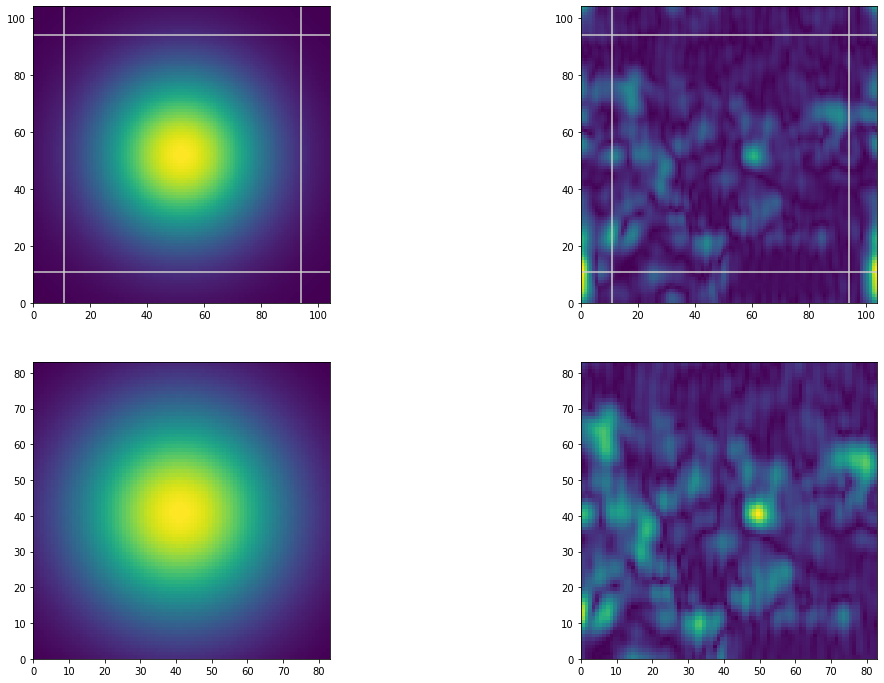

In [163]:
# mm = np.argmin(np.abs(models[:,0]+models[:,1])+np.abs(models[:,0]))
ff=2
# x,y,sigma = models[mm,:]
x,y,sigma = [0,0,0.2]
print([x,y,sigma])

# gather example images
images = val_stim_single_trial_data
batch_inds = np.arange(0,20)
fmaps_complex = _fmaps_fn_complex(torch_utils._to_torch(images[batch_inds],device=device))   
n_features_complex, fmaps_rez = fwrf_fit.get_fmaps_sizes(_fmaps_fn_complex, images[batch_inds], device)

n_pix = fmaps_rez[ff]
g = numpy_utility.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=aperture, dtype=np.float32)
spatial_weights = g[2][0]

images = fmaps_complex[ff][:,0,:,:].view([-1,1,n_pix, n_pix])

[xmin, xmax, ymin, ymax] = get_bbox_from_prf([x,y,sigma], image_size=[n_pix, n_pix], n_prf_sd_out=n_prf_sd_out)
print([xmin, xmax, ymin, ymax])

# first crop out the region of the image that's currently of interest
images_cropped = images[:,:,xmin:xmax, ymin:ymax]
# crop same region from spatial weights matrix
spatial_weights_cropped = spatial_weights[xmin:xmax, ymin:ymax]

import matplotlib.pyplot as plt
plt.figure(figsize=(18,12));

plt.subplot(2,2,1)
plt.pcolormesh(spatial_weights)
plt.axis('square')
plt.axvline(ymin, color=[0.8, 0.8,0.8])
plt.axvline(ymax, color=[0.8, 0.8,0.8])
plt.axhline(xmin, color=[0.8, 0.8,0.8])
plt.axhline(xmax, color=[0.8, 0.8,0.8])

plt.subplot(2,2,2)
plt.pcolormesh(get_value(images[0,0,:,:]))
plt.axis('square')
plt.axvline(ymin, color=[0.8, 0.8,0.8])
plt.axvline(ymax, color=[0.8, 0.8,0.8])
plt.axhline(xmin, color=[0.8, 0.8,0.8])
plt.axhline(xmax, color=[0.8, 0.8,0.8])

plt.subplot(2,2,3)
plt.pcolormesh(spatial_weights_cropped)
plt.axis('square')

plt.subplot(2,2,4)
plt.pcolormesh(get_value(images_cropped[0,0,:,:]))
plt.axis('square')


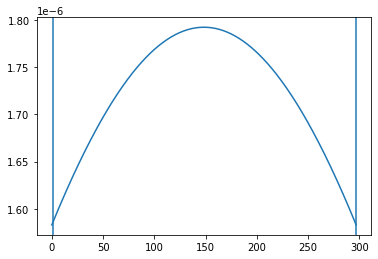

In [57]:
plt.figure();
plt.plot(spatial_weights[center[0],:])
plt.axvline(center[1]+pix_from_center)
plt.axvline(center[1]-pix_from_center)

22
(-0.4, -0.4)
(array([204,  22]), 22)


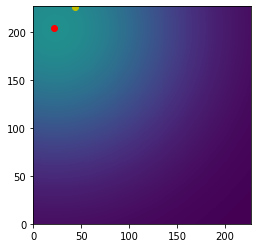

In [68]:
mm=0
# x,y,sigma = models[mm,:]
# x=-0.4; y=0.4;
x=-0.4; y=-0.4
# x=-0.4;y=0
sigma=0.4
n_pix=np.shape(val_stim_single_trial_data)[2]
g = numpy_utility.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=aperture, dtype=np.float32)
spatial_weights = g[2][0]



# decide on the window to use for correlations, based on prf parameters. Patch goes # SD from the center (2 by default).
pix_from_center = int(sigma*n_prf_sd_out*n_pix)
center = np.array((int(n_pix/2  - y*n_pix), int(x*n_pix + n_pix/2 )))
# ensure that the patch never tries to go outside image bounds...at the corners it initially will be outside. 
# TODO: figure out what to do with these edge cases, because padding will probably introduce artifacts.
center = np.minimum(np.maximum(center,0), n_pix-1) 
mindist2edge=np.minimum(n_pix-center[0]-1, n_pix-center[1]-1)
pix_from_center = np.minimum(np.minimum(pix_from_center, np.min(center)), mindist2edge)
pix_from_center = np.maximum(pix_from_center, 0)

print(pix_from_center)

import matplotlib.pyplot as plt
plt.figure();
spatial_weights[center[0], center[1]] = np.max(spatial_weights)*2
plt.pcolormesh(spatial_weights)
print((x,y))
print((center, pix_from_center))
plt.axis('square')
plt.plot(center[1],center[0],'o',color='r')
plt.plot(center[1]+pix_from_center,center[0]+pix_from_center,'o',color='y')

In [217]:
pix_from_center

113

In [160]:
import numpy as np
import torch
import time
from collections import OrderedDict
from utils import numpy_utility, torch_utils
from model_src import fwrf_fit

def compute_all_texture_features(_fmaps_fn_complex, _fmaps_fn_simple, images, prf_params, sample_batch_size=100, include_autocorrs=True, autocorr_output_pix=3, n_prf_sd_out=2, aperture=1.0, device=None):

    if isinstance(prf_params, torch.Tensor):
        prf_params = torch_utils.get_value(prf_params)
    if isinstance(images, torch.Tensor):
        images = torch_utils.get_value(images)
    x,y,sigma = prf_params
    n_pix=np.shape(images)[2]
    g = numpy_utility.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=aperture, dtype=np.float32)
    spatial_weights = g[2][0]

    print('Computing pixel-level statistics...')
    t=time.time()
    wmean, wvar, wskew, wkurt = get_weighted_pixel_features(images, spatial_weights, device=device)
    elapsed =  time.time() - t
    print('time elapsed = %.5f'%elapsed)

    print('Computing complex cell features...')
    t = time.time()
    complex_feature_means = fwrf_fit.get_features_in_prf(prf_params, _fmaps_fn_complex , images=images, sample_batch_size=sample_batch_size, aperture=aperture, device=device)
    elapsed =  time.time() - t
    print('time elapsed = %.5f'%elapsed)

    print('Computing simple cell features...')
    t = time.time()
    simple_feature_means = fwrf_fit.get_features_in_prf(prf_params,  _fmaps_fn_simple, images=images, sample_batch_size=sample_batch_size, aperture=aperture, device=device)
    elapsed =  time.time() - t
    print('time elapsed = %.5f'%elapsed)

    
    if include_autocorrs:
        print('Computing higher order correlations...')
    else:
        print('Computing higher order correlations (SKIPPING AUTOCORRELATIONS)...')
    t = time.time()
    complex_feature_autocorrs, simple_feature_autocorrs, \
    complex_within_scale_crosscorrs, simple_within_scale_crosscorrs, \
    complex_across_scale_crosscorrs, simple_across_scale_crosscorrs = get_higher_order_features(_fmaps_fn_complex, _fmaps_fn_simple, images, prf_params=prf_params, 
                                                                                                sample_batch_size=sample_batch_size, include_autocorrs=include_autocorrs, 
                                                                                                autocorr_output_pix=autocorr_output_pix, n_prf_sd_out=n_prf_sd_out, 
                                                                                                aperture=aperture,  device=device)
    elapsed =  time.time() - t
    print('time elapsed = %.5f'%elapsed)
    
  
  
    
    n_trials = len(wmean)
    if include_autocorrs:
        all_feat = OrderedDict({'wmean': torch_utils.get_value(wmean), 'wvar':torch_utils.get_value(wvar), 'wskew':torch_utils.get_value(wskew), 'wkurt':torch_utils.get_value(wkurt), 'complex_feature_means':complex_feature_means, 'simple_feature_means':simple_feature_means, 
                'complex_feature_autocorrs': np.reshape(complex_feature_autocorrs, [n_trials,-1]), 'simple_feature_autocorrs': np.reshape(simple_feature_autocorrs, [n_trials,-1]), 
                'complex_within_scale_crosscorrs': np.reshape(complex_within_scale_crosscorrs, [n_trials,-1]), 'simple_within_scale_crosscorrs': np.reshape(simple_within_scale_crosscorrs, [n_trials,-1]),
                'complex_across_scale_crosscorrs': np.reshape(complex_across_scale_crosscorrs, [n_trials,-1]), 'simple_across_scale_crosscorrs':np.reshape(simple_across_scale_crosscorrs, [n_trials,-1])})
    else:
        all_feat = OrderedDict({'wmean': torch_utils.get_value(wmean), 'wvar':torch_utils.get_value(wvar), 'wskew':torch_utils.get_value(wskew), 'wkurt':torch_utils.get_value(wkurt), 'complex_feature_means':complex_feature_means, 'simple_feature_means':simple_feature_means,                 
                'complex_within_scale_crosscorrs': np.reshape(complex_within_scale_crosscorrs, [n_trials,-1]), 'simple_within_scale_crosscorrs': np.reshape(simple_within_scale_crosscorrs, [n_trials,-1]),
                'complex_across_scale_crosscorrs': np.reshape(complex_across_scale_crosscorrs, [n_trials,-1]), 'simple_across_scale_crosscorrs':np.reshape(simple_across_scale_crosscorrs, [n_trials,-1])})

    feature_names = list(all_feat.keys())

    for ff, feature_name in enumerate(feature_names): 
        if ff==0:
            all_feat_concat = all_feat[feature_name]
            feature_type_labels = ff*np.ones([1,all_feat[feature_name].shape[1]])
        else:    

            all_feat_concat = np.concatenate((all_feat_concat, all_feat[feature_name]), axis=1)
            feature_type_labels = np.concatenate((feature_type_labels, ff*np.ones([1,all_feat[feature_name].shape[1]])), axis=1)

    print('Final size of features concatenated is [%d x %d]'%(all_feat_concat.shape[0], all_feat_concat.shape[1]))
    print('Feature types included are:')
    print(feature_names)
    
    if np.any(np.isnan(all_feat_concat)):
        print('\nWARNING THERE ARE NANS IN FEATURES MATRIX\n')
            
    return all_feat_concat, [feature_type_labels, feature_names]

def get_higher_order_features(_fmaps_fn_complex, _fmaps_fn_simple, images, prf_params, sample_batch_size=20, include_autocorrs=True, autocorr_output_pix=7, n_prf_sd_out=2, aperture=1.0, device=None):

    """
    Compute all higher-order features (cross-spatial and cross-feature correlations) for a batch of images.
    Input the functions that define first level feature maps (simple and complex cells), and prf parameters.
    Returns arrays of each higher order feature.    
    """
    
    if device is None:
        device = torch.device('cpu:0')    
        
    n_trials = np.shape(images)[0]
    
    assert(np.mod(autocorr_output_pix,2)==1) # must be odd!

    n_features_simple, fmaps_rez = fwrf_fit.get_fmaps_sizes(_fmaps_fn_simple, images[0:sample_batch_size], device)
    n_features_complex, fmaps_rez = fwrf_fit.get_fmaps_sizes(_fmaps_fn_complex, images[0:sample_batch_size], device)
    
    n_sf = len(fmaps_rez)
    n_ori = int(n_features_complex/n_sf)
    n_phases = 2
    
    # all pairs of different orientation channels.
    ori_pairs = np.vstack([[[oo1, oo2] for oo2 in np.arange(oo1+1, n_ori)] for oo1 in range(n_ori) if oo1<n_ori-1])
    n_ori_pairs = np.shape(ori_pairs)[0]

    if include_autocorrs:
        complex_feature_autocorrs = np.zeros([n_trials, n_sf, n_ori, autocorr_output_pix**2])
        simple_feature_autocorrs = np.zeros([n_trials, n_sf, n_ori, n_phases, autocorr_output_pix**2])
    else:
        complex_feature_autocorrs = None
        simple_feature_autocorrs = None
        
    complex_within_scale_crosscorrs = np.zeros([n_trials, n_sf, n_ori_pairs])
    simple_within_scale_crosscorrs = np.zeros([n_trials, n_sf, n_phases, n_ori_pairs])

    complex_across_scale_crosscorrs = np.zeros([n_trials, n_sf-1, n_ori, n_ori])
    simple_across_scale_crosscorrs = np.zeros([n_trials, n_sf-1, n_phases, n_ori, n_ori]) # only done for pairs of neighboring SF.

    x,y,sigma = prf_params

    bb=-1
    for batch_inds, batch_size_actual in numpy_utility.iterate_range(0, n_trials, sample_batch_size):
        bb=bb+1
        
        fmaps_complex = _fmaps_fn_complex(torch_utils._to_torch(images[batch_inds],device=device))   
        fmaps_simple =  _fmaps_fn_simple(torch_utils._to_torch(images[batch_inds],device=device))

        # First looping over frequency (scales)
        for ff in range(n_sf):

            # Scale specific things - get the prf at this resolution of interest
            n_pix = fmaps_rez[ff]
            g = numpy_utility.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=aperture, dtype=np.float32)
            spatial_weights = g[2][0]

            patch_bbox = get_bbox_from_prf(prf_params, spatial_weights.shape, n_prf_sd_out)
          
            # Loop over orientation channels
            xx=-1
            for oo1 in range(n_ori):       


                # Simple cell responses - loop over two phases per orient.
                for pp in range(n_phases):
                    filter_ind = n_phases*oo1+pp  # orients and phases are both listed in the same dimension of filters matrix               
                    simple1 = fmaps_simple[ff][:,filter_ind,:,:].view([batch_size_actual,1,n_pix,n_pix])
                    
                    # Simple cell autocorrelations.
                    if include_autocorrs:
                        auto_corr = torch_utils.get_value(weighted_auto_corr_2d(simple1, spatial_weights, patch_bbox=patch_bbox, output_pix = autocorr_output_pix, subtract_patch_mean = True, enforce_size=True, device=device)) 
                        simple_feature_autocorrs[batch_inds,ff,oo1,pp,:] = np.reshape(auto_corr, [batch_size_actual, autocorr_output_pix**2])

                # Complex cell responses
                complex1 = fmaps_complex[ff][:,oo1,:,:].view([batch_size_actual,1,n_pix,n_pix])

                # Complex cell autocorrelation (correlation w spatially shifted versions of itself)
                if include_autocorrs:
                    auto_corr = torch_utils.get_value(weighted_auto_corr_2d(complex1, spatial_weights, patch_bbox=patch_bbox, output_pix = autocorr_output_pix, subtract_patch_mean = True, enforce_size=True, device=device))       
                    complex_feature_autocorrs[batch_inds,ff,oo1,:] = np.reshape(auto_corr, [batch_size_actual, autocorr_output_pix**2])

                # Within-scale correlations - compare resp at orient==oo1 to responses at all other orientations, same scale.
                for oo2 in np.arange(oo1+1, n_ori):            
                    xx = xx+1 
                    assert(oo1==ori_pairs[xx,0] and oo2==ori_pairs[xx,1])

                    complex2 = fmaps_complex[ff][:,oo2,:,:].view([batch_size_actual,1,n_pix,n_pix])      

                    # Complex cell within-scale cross correlations
                    cross_corr = torch_utils.get_value(weighted_cross_corr_2d(complex1, complex2, spatial_weights, patch_bbox=patch_bbox, subtract_patch_mean = True, device=device))
                   
                    complex_within_scale_crosscorrs[batch_inds,ff,xx] = np.squeeze(cross_corr);

                    # Simple cell within-scale cross correlations
                    for pp in range(n_phases):
                        filter_ind = n_phases*oo2+pp
                        simple2 = fmaps_simple[ff][:,filter_ind,:,:].view([batch_size_actual,1,n_pix,n_pix])

                        cross_corr = torch_utils.get_value(weighted_cross_corr_2d(simple1, simple2, spatial_weights, patch_bbox=patch_bbox, subtract_patch_mean = True, device=device))
                        simple_within_scale_crosscorrs[batch_inds,ff,pp,xx] = np.squeeze(cross_corr);

                # Cross-scale correlations - for these we care about same ori to same ori, so looping over all ori.
                # Only for neighboring scales, so the first level doesn't get one
                if ff>0:

                    for oo2 in range(n_ori):

                        # Complex cell response for neighboring scale
                        complex2_neighborscale = fmaps_complex[ff-1][:,oo2,:,:].view([batch_size_actual,1,fmaps_rez[ff-1], -1])
                        # Resize so that it can be compared w current scale
                        complex2_neighborscale = torch.nn.functional.interpolate(complex2_neighborscale, [n_pix, n_pix], mode='bilinear', align_corners=True)

                        cross_corr = torch_utils.get_value(weighted_cross_corr_2d(complex1, complex2_neighborscale, spatial_weights, patch_bbox=patch_bbox, subtract_patch_mean = True, device=device))
                        complex_across_scale_crosscorrs[batch_inds,ff-1, oo1, oo2] = np.squeeze(cross_corr)

                        for pp in range(n_phases):
                            filter_ind = n_phases*oo2+pp
                            # Simple cell response for neighboring scale
                            simple2_neighborscale = fmaps_simple[ff-1][:,filter_ind,:,:].view([batch_size_actual,1,fmaps_rez[ff-1], -1])
                            simple2_neighborscale = torch.nn.functional.interpolate(simple2_neighborscale, [n_pix, n_pix], mode='bilinear', align_corners=True)

                            cross_corr = torch_utils.get_value(weighted_cross_corr_2d(simple1, simple2_neighborscale, spatial_weights, patch_bbox=patch_bbox, subtract_patch_mean = True, device=device))
                            simple_across_scale_crosscorrs[batch_inds,ff-1, pp, oo1, oo2] = np.squeeze(cross_corr)

    
        
    return complex_feature_autocorrs, simple_feature_autocorrs, complex_within_scale_crosscorrs, simple_within_scale_crosscorrs, complex_across_scale_crosscorrs, simple_across_scale_crosscorrs

def get_bbox_from_prf(prf_params, image_size, n_prf_sd_out=2):
    """
    For a given pRF center and size, calculate the square bounding box that captures a specified number of SDs from the center (default=2 SD)
    Returns [xmin, xmax, ymin, ymax]
    """
    x,y,sigma = prf_params
    n_pix = image_size[0]
    assert(image_size[1]==n_pix)
    assert(sigma>0 and n_prf_sd_out>0)
    
    # decide on the window to use for correlations, based on prf parameters. Patch goes # SD from the center (2 by default).
    pix_from_center = int(sigma*n_prf_sd_out*n_pix)
    # center goes [row ind, col ind]
    center = np.array((int(np.floor(n_pix/2  - y*n_pix)), int(np.floor(x*n_pix + n_pix/2)))) # note that the x/y dims get swapped here because of how pRF parameters are defined.
    # ensure that the patch never tries to go outside image bounds...at the corners it initially will be outside. 
    # TODO: figure out what to do with these edge cases, because padding will probably introduce artifacts. 
    # For now just reducing the size of the region so that it's a square with all corners inside image bounds. 
    center = np.minimum(np.maximum(center,0), n_pix-1) 
   
    mindist2edge=np.min([n_pix-center[0]-1, n_pix-center[1]-1, center[0], center[1]])  
    pix_from_center = np.minimum(pix_from_center, mindist2edge)    
    if pix_from_center==0:
        print('Warning: your patch only has one pixel (for n_pix: %d and prf params: [%.2f, %.2f, %.2f])\n'%(n_pix,x,y,sigma))
        
    assert(not np.any(np.array(center)<pix_from_center) and not np.any(image_size-np.array(center)<=pix_from_center))
    xmin = center[0]-pix_from_center
    xmax = center[0]+pix_from_center+1
    ymin = center[1]-pix_from_center
    ymax = center[1]+pix_from_center+1
        
    return [xmin, xmax, ymin, ymax]

def weighted_auto_corr_2d(images, spatial_weights, patch_bbox=None, output_pix=None, subtract_patch_mean=False, enforce_size=False, device=None):

    """
    Compute autocorrelation of a batch of images, weighting the pixels based on the values in spatial_weights (could be for instance a pRF definition for a voxel).
    Can optionally specify a square patch of the image to compute over, based on "patch_bbox" params. Otherwise use whole image.
    Using fft method to compute, should be fast.
    Input parameters:
        patch_bbox: (optional) bounding box of the patch to use for this calculation. [xmin xmax ymin ymax], see get_bbox_from_prf
        output_pix: the size of the autocorrelation matrix output by this function. If this is an even number, the output size is this value +1. Achieved by cropping out the center of the final autocorrelation 
            matrix  (note that the full image patch is still used in computing the autocorrelation, but just the center values are returned).
            If None, then returns the full autocorrelation matrix (same size as image patch.)
        subtract_patch_mean: subtract weighted mean of image before computing autocorr?
        enforce_size: if image patch is smaller than desired output, should we pad w zeros so that it has to be same size?
    Returns:
        A matrix describing the correlation of the image and various spatially shifted versions of it.
    """
    
    
    if device is None:
        device = torch.device('cpu:0')        
    if isinstance(images, np.ndarray):
        images = torch_utils._to_torch(images, device)
    if isinstance(spatial_weights, np.ndarray):
        spatial_weights = torch_utils._to_torch(spatial_weights, device)
            
    if len(np.shape(images))==2:
        # pretend the batch and channel dims exist, for 2D input only (3D won't work)
        single_image=True
        images = images.view([1,1,images.shape[0],-1])
    else:
        single_image=False
        
    # have to be same size
    assert(images.shape[2]==spatial_weights.shape[0] and images.shape[3]==spatial_weights.shape[1])
    # images is [batch_size x n_channels x nPix x nPix]
    batch_size = images.shape[0]
    n_channels = images.shape[1]    
   
    if patch_bbox is not None:    
        [xmin, xmax, ymin, ymax] = patch_bbox
        # first crop out the region of the image that's currently of interest
        images = images[:,:,xmin:xmax, ymin:ymax]
        # crop same region from spatial weights matrix
        spatial_weights = spatial_weights[xmin:xmax, ymin:ymax]

    # make sure these sum to 1
    if not torch.sum(spatial_weights)==0.0:
        spatial_weights = spatial_weights/torch.sum(spatial_weights)   
   
    spatial_weights = spatial_weights.view([1,1,spatial_weights.shape[0],-1]).expand([batch_size,n_channels,-1,-1]) # [batch_size x n_channels x nPix x nPix]    
    
    # compute autocorrelation of this image patch
    if subtract_patch_mean:

        wmean = torch.sum(torch.sum(images * spatial_weights, dim=3), dim=2) # size is [batch_size x 1]
        wmean = wmean.view([batch_size,-1,1,1]).expand([-1,-1,images.shape[2],images.shape[3]]) # [batch_size x n_channels x nPix x nPix]
        
        weighted_images = (images - wmean) * torch.sqrt(spatial_weights) # square root of the weights here because they will get squared again in next operation
        
        auto_corr = torch.fft.fftshift(torch.real(torch.fft.ifft2(torch.abs(torch.fft.fft2(weighted_images, dim=[2,3]))**2, dim=[2,3])), dim=[2,3]);
    else:
        weighted_images = images * torch.sqrt(spatial_weights)
        auto_corr = torch.fft.fftshift(torch.real(torch.fft.ifft2(torch.abs(torch.fft.fft2(weighted_images, dim=[2,3]))**2, dim=[2,3])), dim=[2,3]);

    if output_pix is not None:

        # crop out just the center region
        new_center = int(np.floor(auto_corr.shape[2]/2))
        n_pix_out = np.min([int(np.floor(output_pix/2)), np.min([new_center, auto_corr.shape[2]-new_center])])
        auto_corr = auto_corr[:,:,new_center-n_pix_out:new_center+n_pix_out+1, new_center-n_pix_out:new_center+n_pix_out+1]        
    
    if enforce_size and not (np.shape(auto_corr)[2]==output_pix or np.shape(auto_corr)[2]==output_pix+1):
        
        # just pad w zeros if want same size.
        pix_diff = output_pix - np.shape(auto_corr)[2]   
        auto_corr = torch.nn.functional.pad(auto_corr, [int(np.ceil(pix_diff/2)), int(np.ceil(pix_diff/2)), int(np.ceil(pix_diff/2)), int(np.ceil(pix_diff/2))], mode='constant', value=0)
        assert(np.shape(auto_corr)[2]==output_pix and np.shape(auto_corr)[3]==output_pix)

    if single_image:
        auto_corr = torch.squeeze(auto_corr)
        
    return auto_corr

def weighted_cross_corr_2d(images1, images2, spatial_weights, patch_bbox=None, subtract_patch_mean=True, device=None):

    """
    Compute cross-correlation of two identically-sized images, weighting the pixels based on the values in spatial_weights (could be for instance a pRF definition for a voxel).
    Can optionally specify a square patch of the image to compute over, based on "patch_bbox" params. Otherwise use whole image.
    Basically a dot product of image values.
    Input parameters:
        patch_bbox: (optional) bounding box of the patch to use for this calculation. [xmin xmax ymin ymax], see get_bbox_from_prf
        subtract_patch_mean: do you want to subtract the weighted mean of image patch before computing?
    Returns:
        A single value that captures correlation between images (zero spatial shift)
            
    """
    
    if device is None:
        device = torch.device('cpu:0')  
    if isinstance(images1, np.ndarray):
        images1 = torch_utils._to_torch(images1, device)
    if isinstance(images2, np.ndarray):
        images2 = torch_utils._to_torch(images2, device)
    if isinstance(spatial_weights, np.ndarray):
        spatial_weights = torch_utils._to_torch(spatial_weights, device)      
    
    if len(np.shape(images1))==2:
        # pretend the batch and channel dims exist, for 2D input only (3D won't work)
        single_image=True
        images1 = images1.view([1,1,images1.shape[0],-1])
        images2 = images2.view([1,1,images2.shape[0],-1])
    else:
        single_image=False
        
    # have to be same size
    assert(images1.shape==images2.shape)
    assert(images1.shape[2]==spatial_weights.shape[0] and images1.shape[3]==spatial_weights.shape[1])
    assert(images2.shape[2]==spatial_weights.shape[0] and images2.shape[3]==spatial_weights.shape[1])
    # images is [batch_size x n_channels x nPix x nPix]
    batch_size = images1.shape[0]
    n_channels = images1.shape[1]
    

    if patch_bbox is not None:
        [xmin, xmax, ymin, ymax] = patch_bbox
        # first crop out the region of the image that's currently of interest
        images1 = images1[:,:,xmin:xmax, ymin:ymax]
        images2 = images2[:,:,xmin:xmax, ymin:ymax]
        # crop same region from spatial weights matrix
        spatial_weights = spatial_weights[xmin:xmax, ymin:ymax]
    
    # make sure the wts sum to 1
    if not torch.sum(spatial_weights)==0.0:
        spatial_weights = spatial_weights/torch.sum(spatial_weights)
    spatial_weights = spatial_weights.view([1,1,spatial_weights.shape[0],-1]).expand([batch_size,n_channels,-1,-1]) # [batch_size x n_channels x nPix x nPix]    
    
    # compute cross-correlation
    if subtract_patch_mean:
        # subtract mean of each weighted image patch and take their dot product.
        # this quantity is equal to weighted covariance (only true if mean-centered)
        wmean1 = torch.sum(torch.sum(images1 * spatial_weights, dim=3), dim=2) # size is [batch_size x 1]
        wmean1 = wmean1.view([batch_size,-1,1,1]).expand([-1,-1,images1.shape[2],images1.shape[3]]) # [batch_size x n_channels x nPix x nPix]
        wmean2 = torch.sum(torch.sum(images2 * spatial_weights, dim=3), dim=2) # size is [batch_size x 1]
        wmean2 = wmean2.view([batch_size,-1,1,1]).expand([-1,-1,images2.shape[2],images2.shape[3]]) # [batch_size x n_channels x nPix x nPix]
        weighted_images1 = (images1 - wmean1) * torch.sqrt(spatial_weights) # square root of the weights here because they will get squared again in dot product operation.
        weighted_images2 = (images2 - wmean2) * torch.sqrt(spatial_weights)

        cross_corr = torch.sum(torch.sum(weighted_images1 * weighted_images2, dim=3), dim=2)    

    else:
        # dot product of raw (weighted) values
        # this is closer to what scipy.signal.correlate2d will do (except this is weighted)
        weighted_images1 = images1 * torch.sqrt(spatial_weights)
        weighted_images2 = images2 * torch.sqrt(spatial_weights)
        cross_corr = torch.sum(torch.sum(weighted_images1 * weighted_images2, dim=3), dim=2)      
        
    if single_image:
        cross_corr = torch.squeeze(cross_corr)
        
    return cross_corr



def get_weighted_pixel_features(image_batch, spatial_weights, device=None):
    """
    Compute mean, variance, skewness, kurtosis of luminance values for each of a batch of images.
    Input size is [batch_size x n_channels x npix x npix]
    Spatial weights describes a weighting function, [npix x npix]
    Returns [batch_size x n_channels] size array for each property.
    """
    
    if isinstance(image_batch, np.ndarray):
        image_batch = torch_utils._to_torch(image_batch, device)
    if isinstance(spatial_weights, np.ndarray):
        spatial_weights = torch_utils._to_torch(spatial_weights, device)
     
    assert(image_batch.shape[2]==spatial_weights.shape[0] and image_batch.shape[3]==spatial_weights.shape[1])
    assert(image_batch.shape[1]==1)
    
    batch_size = image_batch.shape[0]
    n_channels = image_batch.shape[1]
    n_pix = image_batch.shape[2]

    image_batch = image_batch.view([batch_size, n_channels, n_pix**2])
    spatial_weights = spatial_weights/torch.sum(spatial_weights)
    spatial_weights = spatial_weights.view([1,1,n_pix**2]).expand([batch_size,n_channels,-1]) # [batch_size x n_channels x nPix x nPix]    
   
    ims_weighted = image_batch * spatial_weights
   
    wmean = torch.sum(ims_weighted, axis=2).view([batch_size,-1,1])

    wvar = torch.sum(spatial_weights * (image_batch - wmean.expand([-1,-1,n_pix**2]))**2, axis=2).view([batch_size,-1,1])
    
    wskew = torch.sum(spatial_weights *(image_batch - wmean.expand([-1,-1,n_pix**2]))**3 / (wvar**(3/2)), axis=2).view([batch_size,-1,1])
    
    wkurt = torch.sum(spatial_weights *(image_batch - wmean.expand([-1,-1,n_pix**2]))**4 / (wvar**(2)), axis=2).view([batch_size,-1,1])
    
    return torch.squeeze(wmean, dim=2), torch.squeeze(wvar, dim=2), torch.squeeze(wskew, dim=2), torch.squeeze(wkurt, dim=2)


In [6]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from tqdm import tqdm
import pickle
import math
import sklearn
from sklearn import decomposition

import torch
import torch.nn as nn
import torch.nn.init as I
import torch.nn.functional as F
import torch.optim as optim

from utils import numpy_utility, torch_utils
from model_src import texture_statistics

def fit_texture_model_ridge(images, voxel_data, _fmaps_fn_complex, _fmaps_fn_simple, models, lambdas, 
                            aperture=1.0, include_autocorrs=True, autocorr_output_pix=5, n_prf_sd_out=2, zscore=False, sample_batch_size=100, voxel_batch_size=100, 
                            holdout_size=100, shuffle=True, add_bias=False, debug=False):
   
   
    dtype = images.dtype.type
    device = next(_fmaps_fn_complex.parameters()).device
    trn_size = len(voxel_data) - holdout_size
    assert trn_size>0, 'Training size needs to be greater than zero'
    
    print ('trn_size = %d (%.1f%%)' % (trn_size, float(trn_size)*100/len(voxel_data)))
    print ('dtype = %s' % dtype)
    print ('device = %s' % device)
    print ('---------------------------------------')
    
    # First do shuffling of data and define set to hold out
    n_trials = len(images)
    n_prfs = len(models)
    n_voxels = voxel_data.shape[1]
    order = np.arange(len(voxel_data), dtype=int)
    if shuffle:
        np.random.shuffle(order)
    images = images[order]
    voxel_data = voxel_data[order]  
    trn_data = voxel_data[:trn_size]
    out_data = voxel_data[trn_size:]
    
    # Looping over the feature maps once with a batch of images, to get their sizes
    n_features_complex, fmaps_rez = get_fmaps_sizes(_fmaps_fn_complex, images[0:sample_batch_size], device)
    n_sf = len(fmaps_rez)
    n_ori = int(n_features_complex/n_sf)
    ori_pairs = np.vstack([[[oo1, oo2] for oo2 in np.arange(oo1+1, n_ori)] for oo1 in range(n_ori) if oo1<n_ori-1])
    n_ori_pairs = np.shape(ori_pairs)[0]
    n_phases=2
    
    # how many features will be needed, in total?
    if include_autocorrs:
        n_features_total = 4 + n_ori*n_sf + n_ori*n_sf*n_phases \
                + n_ori*n_sf*autocorr_output_pix**2 + n_ori*n_sf*n_phases*autocorr_output_pix**2 \
                + n_sf*n_ori_pairs + n_sf*n_ori_pairs*n_phases + (n_sf-1)*n_ori**2 + (n_sf-1)*n_ori**2*n_phases
    else:
        n_features_total = 4 + n_ori*n_sf + n_ori*n_sf*n_phases \
                + n_sf*n_ori_pairs + n_sf*n_ori_pairs*n_phases + (n_sf-1)*n_ori**2 + (n_sf-1)*n_ori**2*n_phases
        
    # Create full model value buffers    
    best_models = np.full(shape=(n_voxels,), fill_value=-1, dtype=int)   
    best_lambdas = np.full(shape=(n_voxels,), fill_value=-1, dtype=int)
    best_losses = np.full(fill_value=np.inf, shape=(n_voxels), dtype=dtype)
    best_w_params = np.zeros(shape=(n_voxels, n_features_total), dtype=dtype)

    if add_bias:
        best_w_params = np.concatenate([best_w_params, np.ones(shape=(len(best_w_params),1), dtype=dtype)], axis=1)
    features_mean = None
    features_std = None
    if zscore:
        features_mean = np.zeros(shape=(n_voxels, n_features_total), dtype=dtype)
        features_std  = np.zeros(shape=(n_voxels, n_features_total), dtype=dtype)
    
    
    start_time = time.time()
    vox_loop_time = 0
    print ('')
    
    with torch.no_grad():
        
        # Looping over models (here models are different spatial RF definitions)
        for m,(x,y,sigma) in enumerate(models):
            if debug and m>1:
                break
            print('\nmodel %d\n'%m)
            t = time.time()            
            # Get features for the desired pRF, across all trn set image     
            all_feat_concat, feature_info = texture_statistics.compute_all_texture_features(_fmaps_fn_complex, _fmaps_fn_simple, images, 
                                                                         [x,y,sigma], sample_batch_size, include_autocorrs, autocorr_output_pix, 
                                                                         n_prf_sd_out, aperture, device=device)
            features = all_feat_concat
#             print(np.any(np.isnan(features)))
#             features = get_features_in_prf((x,y,sigma), _fmaps_fn, images, sample_batch_size, aperture, device)     
            elapsed = time.time() - t
        
            if zscore:  
                features_m = np.mean(features, axis=0, keepdims=True) #[:trn_size]
                features_s = np.std(features, axis=0, keepdims=True) + 1e-6          
                features -= features_m
                features /= features_s    
                
            if add_bias:
                features = np.concatenate([features, np.ones(shape=(len(features), 1), dtype=dtype)], axis=1)
            
            # separate design matrix into training/held out data (for lambda selection)
            trn_features = features[:trn_size]
            out_features = features[trn_size:]   

#             print(features)
            
            # Send matrices to gpu
            _xtrn = torch_utils._to_torch(trn_features, device=device)
            _xout = torch_utils._to_torch(out_features, device=device)   
            
            # Do part of the matrix math involved in ridge regression optimization out of the loop, 
            # because this part will be same for all the voxels.
#             _cof = _cofactor_fn(_xtrn, lambdas, device=device)
            _cof = _cofactor_fn_cpu(_xtrn, lambdas)
            
            # Now looping over batches of voxels (only reason is because can't store all in memory at same time)
            vox_start = time.time()
            for rv,lv in numpy_utility.iterate_range(0, n_voxels, voxel_batch_size):
                sys.stdout.write('\rfitting model %4d of %-4d, voxels [%6d:%-6d] of %d' % (m, n_prfs, rv[0], rv[-1], n_voxels))

                # Send matrices to gpu
                _vtrn = torch_utils._to_torch(trn_data[:,rv], device=device)
                _vout = torch_utils._to_torch(out_data[:,rv], device=device)

                # Here is where optimization happens - relatively simple matrix math inside loss fn.
                _betas, _loss = _loss_fn(_cof, _vtrn, _xout, _vout) #   [#lambda, #feature, #voxel, ], [#lambda, #voxel]
                # Now have a set of weights (in betas) and a loss value for every voxel and every lambda. 
                # goal is then to choose for each voxel, what is the best lambda and what weights went with that lambda.
                
                # first choose best lambda value and the loss that went with it.
                _values, _select = torch.min(_loss, dim=0)
                betas = torch_utils.get_value(_betas)
                values, select = torch_utils.get_value(_values), torch_utils.get_value(_select)

                # comparing this loss to the other models for each voxel (e.g. the other RF position/sizes)
                imp = values<best_losses[rv]
                
                if np.sum(imp)>0:                    
                    # for whichever voxels had improvement relative to previous models, save parameters now
                    # this means we won't have to save all params for all models, just best.
                    arv = np.array(rv)[imp]
                    li = select[imp]
                    best_lambdas[arv] = li
                    best_losses[arv] = values[imp]
                    best_models[arv] = m
                    if zscore:
                        features_mean[arv] = features_m # broadcast over updated voxels
                        features_std[arv]  = features_s
                    # taking the weights associated with the best lambda value
                    best_w_params[arv,:] = numpy_utility.select_along_axis(betas[:,:,imp], li, run_axis=2, choice_axis=0).T
              
            vox_loop_time += (time.time() - vox_start)
            elapsed = (time.time() - vox_start)

    # Print information about how fitting went...
    total_time = time.time() - start_time
    inv_time = total_time - vox_loop_time
    return_params = [best_w_params[:,:n_features_total],]
    if add_bias:
        return_params += [best_w_params[:,-1],]
    else: 
        return_params += [None,]
    print ('\n---------------------------------------')
    print ('total time = %fs' % total_time)
    print ('total throughput = %fs/voxel' % (total_time / n_voxels))
    print ('voxel throughput = %fs/voxel' % (vox_loop_time / n_voxels))
    print ('setup throughput = %fs/model' % (inv_time / n_prfs))
    sys.stdout.flush()
    return best_losses, best_lambdas, [models[best_models],]+return_params+[features_mean, features_std]+[best_models], feature_info


In [132]:
best_losses

array([83.782   , 62.553474, 67.68647 , ..., 94.80136 , 64.067856,
       66.55217 ], dtype=float32)

(479, 3)
[[-0.4        -0.4         0.04      ]
 [-0.34285714 -0.4         0.04      ]
 [-0.28571429 -0.4         0.04      ]
 ...
 [ 0.4        -0.4         0.40000001]
 [-0.4         0.4         0.40000001]
 [ 0.4         0.4         0.40000001]]


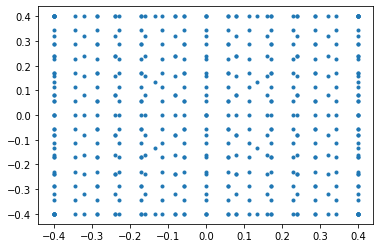

In [187]:
aperture = np.float32(1)
smin, smax = np.float32(0.04), np.float32(0.4)
n_sizes = 8

# models is three columns, x, y, sigma
models = rf_grid.model_space_pyramid(rf_grid.logspace(n_sizes)(smin, smax), min_spacing=1.4, aperture=0.8*aperture)    

print(models.shape)
print(models)

plt.figure();
plt.plot(models[:,0], models[:,1], '.')

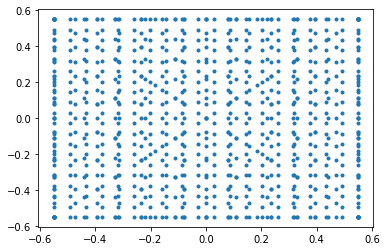

In [162]:
val_cc, val_r2 = validate_texture_model(best_params, val_voxel_single_trial_data, val_stim_single_trial_data, 
                                        _fmaps_fn_complex, _fmaps_fn_simple, sample_batch_size, voxel_batch_size, 
                                        autocorr_output_pix=5, n_prf_sd_out=2, aperture=aperture, dtype=fpX)

features_each_model_val, voxel_feature_correlations_val = get_voxel_texture_feature_corrs(best_params, models, _fmaps_fn_complex, _fmaps_fn_simple, val_voxel_single_trial_data, 
                                                                                                    val_stim_single_trial_data, sample_batch_size, autocorr_output_pix=5, n_prf_sd_out=2, aperture=aperture, dtype=fpX, device=device, debug=True)


Computing activation in each feature channel on validation set trials...

model 0 of 875Computing pixel-level statistics...
time elapsed = 0.01179
Computing complex cell features...
time elapsed = 0.14639
Computing simple cell features...
time elapsed = 0.07997
Computing higher order correlations...
time elapsed = 5.21347
Concatenating features...
model 1 of 875Computing pixel-level statistics...
time elapsed = 0.00232
Computing complex cell features...
time elapsed = 0.11636
Computing simple cell features...
time elapsed = 0.06663
Computing higher order correlations...
time elapsed = 5.09848
Concatenating features...

Computing voxel/feature correlations for validation set trials...

voxel 1 of 2392


Initializing model for validation...

Creating FWRF texture model...

Getting model predictions on validation set...

samples [    0:9    ] of 62, voxels [     0:0     ] of 2392Computing pixel-level statistics...
time elapsed = 0.00160
Computing complex cell features...
time elapsed = 0.05269
Computing simple cell features...
time elapsed = 0.02797
Computing higher order correlations...
time elapsed = 0.73243
Concatenating features...
samples [   10:19   ] of 62, voxels [     0:0     ] of 2392Computing pixel-level statistics...
time elapsed = 0.00096
Computing complex cell features...
time elapsed = 0.03595
Computing simple cell features...
time elapsed = 0.02153
Computing higher order correlations...
time elapsed = 0.64725
Concatenating features...
samples [   20:29   ] of 62, voxels [     0:0     ] of 2392Computing pixel-level statistics...
time elapsed = 0.00095
Computing complex cell features...
time elapsed = 0.03390
Computing simple cell features...
time elapsed = 0.02025
Comput

  0%|          | 0/2392 [00:00<?, ?it/s]/home/mmhender/myenv/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/mmhender/myenv/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 20%|██        | 489/2392 [00:00<00:00, 4887.62it/s]


Evaluating correlation coefficient on validation set...



100%|██████████| 2392/2392 [00:00<00:00, 5077.62it/s]


In [221]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from tqdm import tqdm
import pickle
import math
import sklearn
from sklearn import decomposition

import torch
import torch.nn as nn
import torch.nn.init as I
import torch.nn.functional as F
import torch.optim as optim

from utils import numpy_utility, torch_utils
from model_src import fwrf_fit, texture_statistics



def validate_texture_model(best_params, val_voxel_single_trial_data, val_stim_single_trial_data, _fmaps_fn_complex, 
                           _fmaps_fn_simple, sample_batch_size, voxel_batch_size, include_autocorrs=True, autocorr_output_pix=5, n_prf_sd_out=2, 
                           aperture=1.0, dtype=np.float32):
    
    # EVALUATE PERFORMANCE ON VALIDATION SET
    
    print('\nInitializing model for validation...\n')
    param_batch = [p[:voxel_batch_size] if p is not None else None for p in best_params]
    # To initialize this module for prediction, need to take just first batch of voxels.
    # Will eventually pass all voxels through in batches.
    _fwd_model = texture_model(_fmaps_fn_complex, _fmaps_fn_simple, param_batch, 
                   input_shape=val_stim_single_trial_data.shape, include_autocorrs=include_autocorrs, autocorr_output_pix=5, n_prf_sd_out=2, aperture=1.0)

    print('\nGetting model predictions on validation set...\n')
    val_voxel_pred = get_predictions_texture_model(val_stim_single_trial_data, _fwd_model, best_params, sample_batch_size=sample_batch_size, debug=True)

    # val_cc is the correlation coefficient bw real and predicted responses across trials, for each voxel.
    n_voxels = np.shape(val_voxel_single_trial_data)[1]
    val_cc  = np.zeros(shape=(n_voxels), dtype=dtype)
    val_r2 = np.zeros(shape=(n_voxels), dtype=dtype)
    
    print('\nEvaluating correlation coefficient on validation set...\n')
    for v in tqdm(range(n_voxels)):    
        val_cc[v] = np.corrcoef(val_voxel_single_trial_data[:,v], val_voxel_pred[:,v])[0,1]  
        val_r2[v] = get_r2(val_voxel_single_trial_data[:,v], val_voxel_pred[:,v])
        
    val_cc = np.nan_to_num(val_cc)
    val_r2 = np.nan_to_num(val_r2)    
    
    return val_cc, val_r2

def get_voxel_texture_feature_corrs(best_params, models, _fmaps_fn_complex, _fmaps_fn_simple, val_voxel_single_trial_data, 
                                    val_stim_single_trial_data, sample_batch_size, include_autocorrs=True, autocorr_output_pix=5, n_prf_sd_out=2, 
                                    aperture=1.0, device=None, debug=False, dtype=np.float32):
    
    # Directly compute linear correlation bw each voxel's response and value of each feature channel.
    
    ### GET ACTUAL FEATURE VALUES FOR EACH TRIAL IN TESTING SET ########
    # will use to compute tuning etc based on voxel responses in validation set.
    # looping over every model here; there are fewer models than voxels so this is faster than doing each voxel separately.

    print('\nComputing activation in each feature channel on validation set trials...\n')
    n_features = best_params[1].shape[1]
    n_prfs = models.shape[0]
    n_trials_val, n_voxels = np.shape(val_voxel_single_trial_data)
    features_each_model_val = np.zeros(shape=(n_trials_val, n_features, n_prfs),dtype=dtype)
   
    for mm in range(n_prfs):
        if debug and mm>1:
            break 
        sys.stdout.write('\rmodel %d of %d'%(mm,n_prfs))
        
        all_feat_concat, feature_info = texture_statistics.compute_all_texture_features(_fmaps_fn_complex, _fmaps_fn_simple, val_stim_single_trial_data, 
                                                                         models[mm,:], sample_batch_size, include_autocorrs, autocorr_output_pix, 
                                                                         n_prf_sd_out, aperture, device=device)

        features_each_model_val[:,:,mm] = all_feat_concat

        
    ### COMPUTE CORRELATION OF VALIDATION SET VOXEL RESP WITH FEATURE ACTIVATIONS ###########
    # this will serve as a measure of "tuning"
    print('\nComputing voxel/feature correlations for validation set trials...\n')
    voxel_feature_correlations_val = np.zeros((n_voxels, n_features),dtype=dtype)
    best_models = best_params[0]
    best_model_inds = best_params[5]
    
    for vv in range(n_voxels):
        if debug and vv>1:
            break 
        sys.stdout.write('\rvoxel %d of %d'%(vv,n_voxels))
        
        # figure out for this voxel, which pRF estimate was best.
        best_model_ind = best_model_inds[vv]
        # taking features for the validation set images, within this voxel's fitted RF
        features2use = features_each_model_val[:,:,best_model_ind]
       
        for ff in range(n_features):        
            voxel_feature_correlations_val[vv,ff] = np.corrcoef(features2use[:,ff], val_voxel_single_trial_data[:,vv])[0,1]
           
    return features_each_model_val, voxel_feature_correlations_val


In [137]:
print('\nInitializing model for validation...\n')

gc.collect()
torch.cuda.empty_cache()

best_params[4] = np.ones(np.shape(best_params[4])).astype('float32')
voxel_batch_size=1
param_batch = [p[:voxel_batch_size] if p is not None else None for p in best_params]
_fwd_model = texture_model(_fmaps_fn_complex, _fmaps_fn_simple, param_batch, 
                   input_shape=val_stim_single_trial_data.shape, autocorr_output_pix=5, n_prf_sd_out=2, aperture=1.0)

print('\nGetting model predictions on validation set...\n')
val_voxel_pred = get_predictions_texture_model(val_stim_single_trial_data, _fwd_model, best_params, sample_batch_size=sample_batch_size, debug=True)
    


Initializing model for validation...

Creating FWRF texture model...

Getting model predictions on validation set...

samples [    0:9    ] of 62, voxels [     0:0     ] of 2392Computing pixel-level statistics...
time elapsed = 0.00121
Computing complex cell features...
time elapsed = 0.04027
Computing simple cell features...
time elapsed = 0.02324
Computing higher order correlations...


/user_data/mmhender/imStat/code/model_src/fwrf_fit.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _x = torch.tensor(image_batch).to(device) # the input variable.


time elapsed = 0.78072
Concatenating features...
samples [   10:19   ] of 62, voxels [     0:0     ] of 2392Computing pixel-level statistics...
time elapsed = 0.00096
Computing complex cell features...
time elapsed = 0.03585
Computing simple cell features...
time elapsed = 0.01941
Computing higher order correlations...
time elapsed = 0.64435
Concatenating features...
samples [   20:29   ] of 62, voxels [     0:0     ] of 2392Computing pixel-level statistics...
time elapsed = 0.00096
Computing complex cell features...
time elapsed = 0.03229
Computing simple cell features...
time elapsed = 0.02229
Computing higher order correlations...
time elapsed = 0.64145
Concatenating features...
samples [   30:39   ] of 62, voxels [     0:0     ] of 2392Computing pixel-level statistics...
time elapsed = 0.00096
Computing complex cell features...
time elapsed = 0.03259
Computing simple cell features...
time elapsed = 0.02284
Computing higher order correlations...
time elapsed = 0.64139
Concatenating 

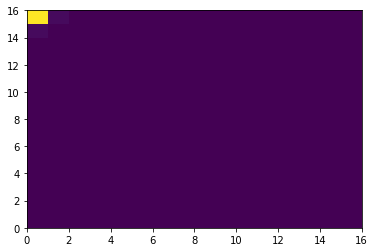

In [105]:
mm=0
n_pix=16
_prfs = numpy_utility.make_gaussian_mass(models[mm,0], models[mm,1], models[mm,2], n_pix, size=1.0)

prf = _prfs[2]
import matplotlib.pyplot as plt
plt.figure();
plt.pcolormesh(prf)

In [130]:
x=-0.55; y=0
sigma=0.2
n_pix=16
pix_from_center = int(sigma*n_prf_sd_out*n_pix)
center = np.array((int(y*n_pix+n_pix/2), int(x*n_pix+n_pix/2)))
# ensure that the patch never tries to go outside image bounds...at the corners it initially will be outside. 
center = np.minimum(np.maximum(center,0), n_pix-1) 
mindist2edge=np.minimum(n_pix-center[0]-1, n_pix-center[1]-1)
pix_from_center = np.minimum(np.minimum(pix_from_center, np.min(center)), mindist2edge)
pix_from_center = np.maximum(pix_from_center, 0)

print(center)
print(pix_from_center)

[8 0]
0


In [129]:
mindist2edge

0